## Back Test Results Binary Classification

In [1]:
import pandas as pd
from datetime import datetime, timezone
from pycaret.datasets import get_data
from pycaret.classification import *
import yaml
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open ('back_test_pipeline_settings.yaml') as ymlfile:
    cfg = yaml.safe_load(ymlfile)
    pair = cfg['currency']['pair_1']
    dt = cfg['model']['dt']
    et = cfg['model']['et']
    knn = cfg['model']['knn'] 
    rf = cfg['model']['rf']
    ada = cfg['model']['ada']
    gbc = cfg['model']['gbc']
    svm = cfg['model']['svm']
    lightgbm = cfg['model']['lightgbm']
    lr = cfg['model']['lr']
    ridge = cfg['model']['ridge']
    lda = cfg['model']['lda']
    qda = cfg['model']['qda']
    nb = cfg['model']['nb']
    frac = cfg['model']['frac']
    random_state = cfg['model']['random_state']

In [3]:
now = datetime.now()
today = now.strftime("%d-%m-%Y_%I-%M_%p")

In [4]:
dataset = pd.read_csv('Back_Test_Result.csv')
dataset.shape

(4000, 11)

In [5]:
dataset.head()

,Candle_No,Current_Market_Fit,Current_Market,Rec1_Score,Rec1_Prediction,Rec2_Score,Rec2_Prediction,Rec3_Score,Rec3_Prediction,Rec4_Score,Rec4_Prediction
0,4020.0,71.0,Bullish,88.0,BUY,1.0,SELL,56.0,BUY,9.0,BUY
1,3982.0,51.0,Bearish,58.0,SELL,0.0,SELL,91.0,BUY,28.0,BUY
2,2662.0,57.0,Bullish,75.0,BUY,80.0,SELL,1.0,BUY,92.0,BUY
3,994.0,41.0,Bearish,2.0,BUY,21.0,BUY,63.0,BUY,0.0,SELL
4,5200.0,0.0,Bullish,38.0,SELL,38.0,SELL,63.0,SELL,75.0,SELL


## Drop Predictions with Less than 20% LR Fit

In [6]:
dataset = dataset[dataset['Current_Market_Fit'] > 20]
dataset = dataset.reset_index()
del dataset['index']

In [7]:
dataset.shape

(2869, 11)

## One-Hot Encoding

In [8]:
dataset['Current_Market'] = dataset['Current_Market'].replace(['Bullish','Bearish'],[1,0])
dataset['Rec1_Prediction'] = dataset['Rec1_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec2_Prediction'] = dataset['Rec2_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec3_Prediction'] = dataset['Rec3_Prediction'].replace(['BUY','SELL'],[1,-1])
dataset['Rec4_Prediction'] = dataset['Rec4_Prediction'].replace(['BUY','SELL'],[1,-1])

In [9]:
dataset['Rec1_Score'] = dataset['Rec1_Score'] * dataset['Rec1_Prediction']
dataset['Rec2_Score'] = dataset['Rec2_Score'] * dataset['Rec2_Prediction']
dataset['Rec3_Score'] = dataset['Rec3_Score'] * dataset['Rec3_Prediction']
dataset['Rec4_Score'] = dataset['Rec4_Score'] * dataset['Rec4_Prediction']

In [10]:
dataset = dataset.drop([
    'Candle_No',
    'Current_Market_Fit',
    'Rec1_Prediction',
    'Rec2_Prediction',
    'Rec3_Prediction',
    'Rec4_Prediction',
], axis=1)

In [11]:
dataset.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,88.0,-1.0,56.0,9.0
1,0,-58.0,-0.0,91.0,28.0
2,1,75.0,-80.0,1.0,92.0
3,0,2.0,21.0,63.0,-0.0
4,1,-49.0,-73.0,-67.0,8.0


In [12]:
data = dataset.sample(frac=frac, random_state=random_state).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (2008, 5)
Unseen Data For Predictions: (861, 5)


# Create Unseen DataFrame

In [13]:
data_unseen.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score
0,1,-84.0,8.0,-22.0,49.0
1,1,-4.0,64.0,-69.0,-26.0
2,1,0.0,72.0,62.0,-0.0
3,0,-93.0,-50.0,-26.0,68.0
4,0,-93.0,81.0,-29.0,-83.0


In [14]:
exp_clf101 = setup(data = data, target = 'Current_Market', session_id=123, silent=True) 

,Description,Value
0,session_id,123
1,Target,Current_Market
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2008, 5)"
5,Missing Values,False
6,Numeric Features,4
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [15]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.5317,0.5290,0.5399,0.5318,0.5353,0.0634,0.0636,0.0140
gbc,Gradient Boosting Classifier,0.5238,0.5343,0.5399,0.5247,0.5317,0.0477,0.0478,0.0210
ada,Ada Boost Classifier,0.5210,0.5446,0.5555,0.5212,0.5367,0.0418,0.0424,0.0160
svm,SVM - Linear Kernel,0.5146,0.0000,0.5001,0.5176,0.5072,0.0293,0.0298,0.0050
rf,Random Forest Classifier,0.5054,0.5075,0.4789,0.5062,0.4913,0.0109,0.0109,0.0520
lr,Logistic Regression,0.5039,0.5125,0.5355,0.5049,0.5191,0.0076,0.0077,0.2150
lda,Linear Discriminant Analysis,0.5039,0.5124,0.5355,0.5049,0.5191,0.0076,0.0077,0.0060
ridge,Ridge Classifier,0.5032,0.0000,0.5341,0.5043,0.5182,0.0062,0.0063,0.0050
dt,Decision Tree Classifier,0.4982,0.4981,0.4927,0.4970,0.4930,-0.0037,-0.0031,0.0060
et,Extra Trees Classifier,0.4961,0.5131,0.4903,0.4969,0.4929,-0.0075,-0.0076,0.0440


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [16]:
best_model = lightgbm

In [17]:
MODEL = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5035,0.5374,0.4714,0.5000,0.4853,0.0066,0.0067
1,0.5532,0.5535,0.5211,0.5606,0.5401,0.1068,0.1071
2,0.5532,0.5173,0.5634,0.5556,0.5594,0.1062,0.1063
3,0.5106,0.4819,0.4789,0.5152,0.4964,0.0217,0.0218
4,0.4965,0.5266,0.5070,0.5000,0.5035,-0.0072,-0.0072
5,0.5286,0.5227,0.5286,0.5286,0.5286,0.0571,0.0571
6,0.5357,0.4986,0.5571,0.5342,0.5455,0.0714,0.0715
7,0.5500,0.5818,0.6143,0.5443,0.5772,0.1000,0.1008
8,0.5429,0.5331,0.5714,0.5405,0.5556,0.0857,0.0859
9,0.5429,0.5373,0.5857,0.5395,0.5616,0.0857,0.0860


In [18]:
TUNED_MODEL = tune_model(MODEL)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.5603,0.5505,0.5571,0.5571,0.5571,0.1205,0.1205
1,0.5461,0.5380,0.5493,0.5493,0.5493,0.0922,0.0922
2,0.5319,0.5370,0.5211,0.5362,0.5286,0.0640,0.0640
3,0.5035,0.4891,0.5211,0.5068,0.5139,0.0068,0.0068
4,0.5177,0.5632,0.4930,0.5224,0.5072,0.0358,0.0359
5,0.5143,0.4941,0.5571,0.5132,0.5342,0.0286,0.0287
6,0.5429,0.5090,0.5714,0.5405,0.5556,0.0857,0.0859
7,0.5786,0.5761,0.5714,0.5797,0.5755,0.1571,0.1572
8,0.5643,0.5967,0.5714,0.5634,0.5674,0.1286,0.1286
9,0.5071,0.5431,0.4571,0.5079,0.4812,0.0143,0.0144


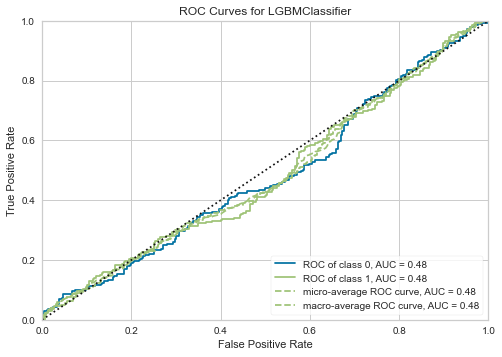

In [19]:
plot_model(TUNED_MODEL, plot = 'auc')

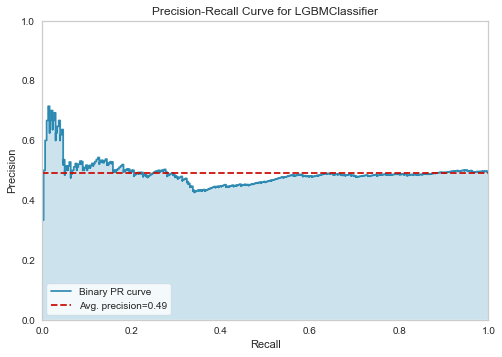

In [20]:
plot_model(TUNED_MODEL, plot = 'pr')

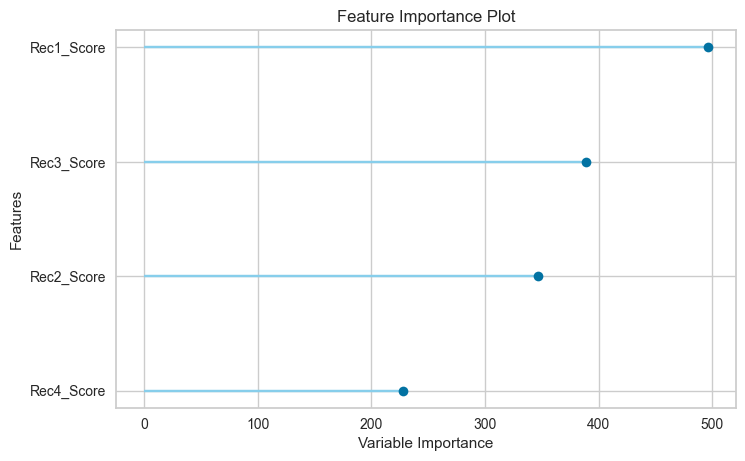

In [21]:
plot_model(TUNED_MODEL, plot='feature')

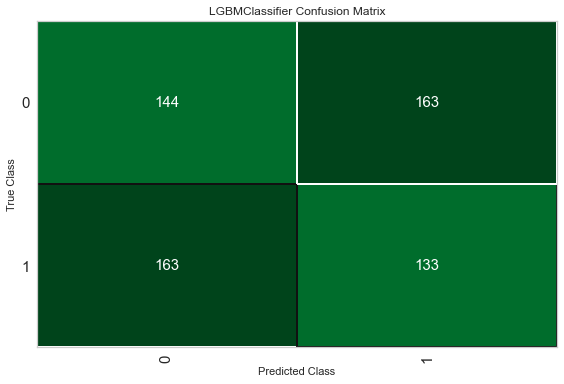

In [22]:
plot_model(TUNED_MODEL, plot = 'confusion_matrix')

In [23]:
predict_model(TUNED_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.4594,0.4809,0.4493,0.4493,0.4493,-0.0816,-0.0816


In [24]:
FINAL_MODEL = finalize_model(TUNED_MODEL)

In [25]:
print(FINAL_MODEL)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


In [26]:
predict_model(FINAL_MODEL);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9768,0.9978,0.9797,0.9732,0.9764,0.9536,0.9536


In [27]:
unseen_predictions = predict_model(FINAL_MODEL, data=data_unseen)
unseen_predictions.head()

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-84.0,8.0,-22.0,49.0,0,0.6989
1,1,-4.0,64.0,-69.0,-26.0,1,0.9115
2,1,0.0,72.0,62.0,-0.0,1,0.8735
3,0,-93.0,-50.0,-26.0,68.0,0,0.5833
4,0,-93.0,81.0,-29.0,-83.0,0,0.5688


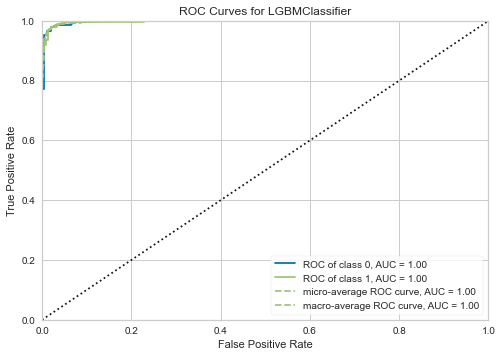

In [28]:
plot_model(FINAL_MODEL, plot = 'auc')

In [29]:
pkl_name = (today + "_" + lightgbm + "_" + pair)

In [30]:
save_model(FINAL_MODEL, pkl_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='Current_Market',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nume...
                                 colsample_bytree=1.0, feature_fraction=0.5,
                                 importance_type='split', learning_rate=0.4,
                                 max_depth=-1, min_child_samples=6,
             

In [31]:
SAVED_FINAL_MODEL = load_model(pkl_name)

Transformation Pipeline and Model Successfully Loaded


In [32]:
new_prediction = predict_model(SAVED_FINAL_MODEL, data=data_unseen)

In [33]:
new_prediction.head(20)

,Current_Market,Rec1_Score,Rec2_Score,Rec3_Score,Rec4_Score,Label,Score
0,1,-84.0,8.0,-22.0,49.0,0,0.6989
1,1,-4.0,64.0,-69.0,-26.0,1,0.9115
2,1,0.0,72.0,62.0,-0.0,1,0.8735
3,0,-93.0,-50.0,-26.0,68.0,0,0.5833
4,0,-93.0,81.0,-29.0,-83.0,0,0.5688
5,1,16.0,-1.0,9.0,-84.0,1,0.7853
6,1,84.0,58.0,-69.0,62.0,1,0.9603
7,0,62.0,-4.0,69.0,16.0,0,0.7626
8,1,42.0,-61.0,-31.0,-16.0,1,0.6883
9,1,91.0,-43.0,17.0,-3.0,0,0.5270


In [35]:
file = open(today + "_" + "binary_classification_log.txt", "w")
file.write ("Date: " + today + "\n" + \
            "Currency Pair: " + pair + "\n" + \
            "Model: " + best_model + "\n" + \
            "Frac: " + str(frac) + "\n" + \
            "Random State: " + str(random_state) + "\n" )
file.close()